# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")
print("azdias data file shape:{}".format(azdias.shape))

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")
print("feature summary file shape:{}".format(feat_info.shape))

azdias data file shape:(891221, 85)
feature summary file shape:(85, 4)


In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

display(azdias.head())
display(azdias.describe())

display(feat_info.head())
display(feat_info.describe())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ALTER_HH,person,ordinal,[-1]
freq,1,43,49,26


In [5]:
# Get data type and counts
azdias.dtypes.value_counts()

float64    49
int64      32
object      4
dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.

# Identify columns with missing data
azdias[azdias.columns].isnull().sum().sort_values(ascending=False)


KK_KUNDENTYP             584612
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_BAUMAX             133324
KBA05_GBZ                133324
MOBI_REGIO               133324
REGIOTYP                 121196
KKK                      121196
PLZ8_ANTG3               116515
PLZ8_ANTG1               116515
PLZ8_GBZ                 116515
PLZ8_ANTG2               116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
W_KEIT_KIND_HH           107602
KBA13_ANZAHL_PKW         105800
CAMEO_INTL_2015           98979
CAMEO_DEU_2015            98979
CAMEO_DEUG_2015           98979
ORTSGR_KLS9               97216
ARBEIT                    97216
RELAT_AB                  97216
ANZ_HH_TITEL              97008
BALLRAUM                  93740
EWDICHTE                  93740
INNENSTADT                93740
GEBAEUDETYP_RASTER        93155
                          ...  
FINANZ_H

In [7]:
# Total number of missing values in all columns
print("Total number of Naturally missing values: {}". format(azdias[azdias.columns].isnull().sum().sum()))

# % of fields with missing values
print("% of Naturally missing values: {}". format((azdias[azdias.columns].isnull().sum().sum())/len(azdias)))

Total number of Naturally missing values: 4896838
% of Naturally missing values: 5.49452717115059


In [8]:
for index in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[index]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[index]['attribute']: missing_or_unknown}, np.nan)

In [9]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [10]:
# Total number of missing or unknown values in all columns
print("Total number of missing or unknown values: {}". format(azdias[azdias.columns].isnull().sum().sum()))

# % of fields with missing or unknown values
print("% of missing or unknown values: {}". format((azdias[azdias.columns].isnull().sum().sum())/len(azdias)))

Total number of missing or unknown values: 8373929
% of missing or unknown values: 9.396018495973502


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_per_column = (azdias.isnull().sum())/len(azdias)*100

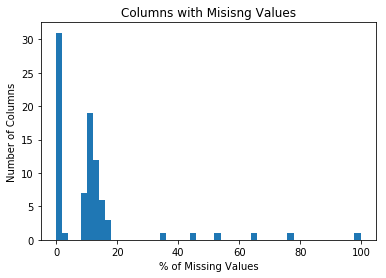

In [12]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_per_column, bins=50)
plt.ylabel("Number of Columns")
plt.xlabel("% of Missing Values")
plt.title("Columns with Misisng Values")
plt.show()

In [13]:
#get and print outlier columns
outlier_columns = missing_per_column[missing_per_column>20].index.tolist()
print(outlier_columns)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias = azdias.drop(outlier_columns, axis=1)
print("New azdias shape after deleting outlier columns: {}".format(azdias.shape))
azdias.head()

New azdias shape after deleting outlier columns: (891221, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

Based on the histogram above we can see that 79 out of 85 columns have less than 20% of missing data. 6 columns have more than 20% of the missing data and these columns are spread out meaning there is no pattern on these 6 columns. So we can consider these 6 columns as outlier columns and delete those columns from the dataset. The outlier columns are ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'].

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

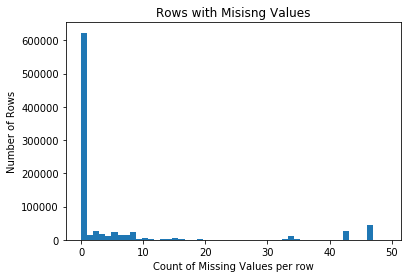

In [15]:
# How much data is missing in each row of the dataset?
missing_per_row = azdias.isnull().sum(axis=1)
plt.hist(missing_per_row, bins=50)
plt.ylabel("Number of Rows")
plt.xlabel("Count of Missing Values per row")
plt.title("Rows with Misisng Values")
plt.show()

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_b30 = azdias[missing_per_row<=30]
azdias_a30 = azdias[missing_per_row>30]
print("No.of rows where misisng values are less than 30: {}".format(len(azdias_b30)))
print("No.of rows where misisng values are greater than 30: {}".format(len(azdias_a30)))

No.of rows where misisng values are less than 30: 798067
No.of rows where misisng values are greater than 30: 93154


In [17]:
# columns with no missing data

columns_zero_missing = missing_per_column[missing_per_column==0].index.tolist()
columns_zero_missing

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# function to plot and compare the distribution between 2 subsets

def compare_distribution(column_name):
    fig = plt.figure(10, figsize = (14,4))
    
    axs1 = fig.add_subplot(1,2,1)
    axs1.title.set_text("No Missing Values")
    sns.countplot(azdias_b30[column_name])
    
    axs2 = fig.add_subplot(1,2,2)
    axs2.title.set_text("Missing Values")
    sns.countplot(azdias_a30[column_name])
    
    fig.suptitle(column_name)
    plt.show()

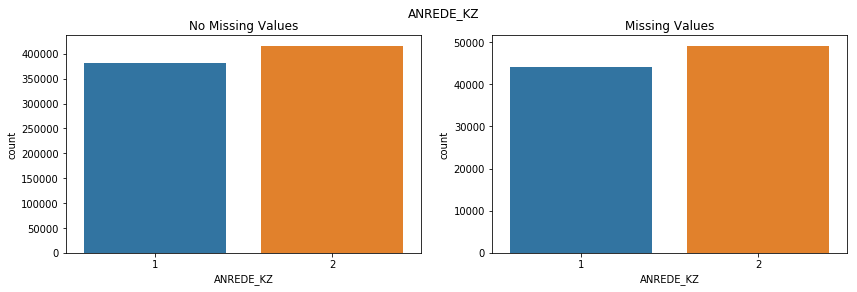

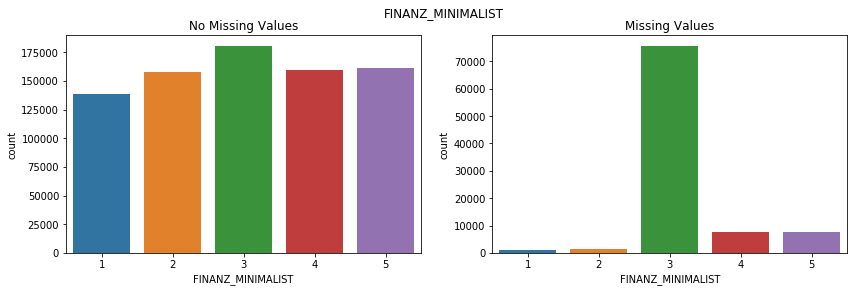

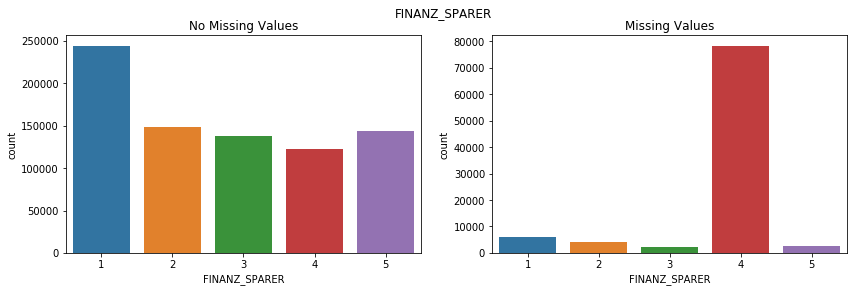

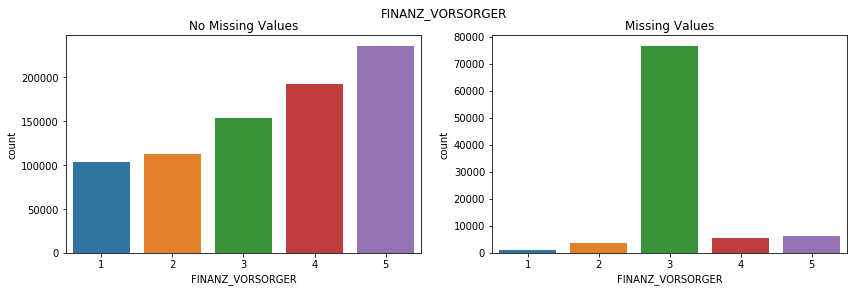

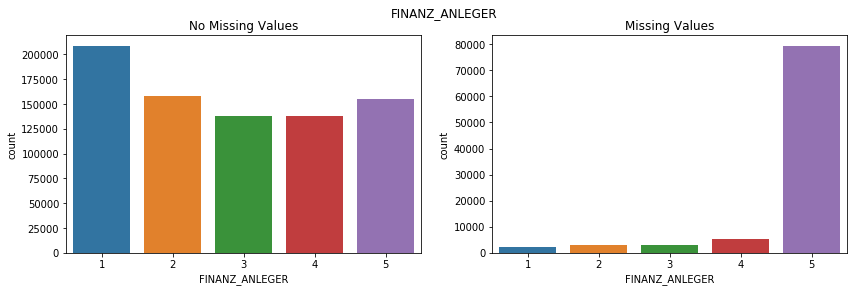

In [19]:
# Run the campare distribution funtion on 8 zero misisng columns

for i in range(5):
    compare_distribution(columns_zero_missing[i])

In [20]:
azdias_b30 = azdias_b30.fillna(azdias_b30.mode().iloc[0])

#### Discussion 1.1.3: Assess Missing Data in Each Row

Except for ANREDE_KZ the distribution of all the other columns is quite different between the 2 subsets. For further analysis we will just use the subset of data where misisng fields in rows in rows is less than 30. for the subset set of rows where misisng values are less than 30, we still have some NaN's. For these NaN values we imputed the most frequently used value (mode).

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
# get all columns from feat_info which are in azdias file. Since we removed 6 columns from azdias file,
#we should not be considerign those columns in feat_info

feat_info[feat_info.attribute.isin(list(azdias.columns.values))]

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


In [22]:
# How many features are there of each data type?

feat_info = feat_info[feat_info.attribute.isin(list(azdias.columns.values))]
feat_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
categorical_variables = feat_info[feat_info['type'] == "categorical"]["attribute"]
categorical_variables

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [24]:
#get unique values in column
azdias_b30['ALTERSKATEGORIE_GROB'].nunique()

4

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

binary_col = []
multi_col = []

for column in categorical_variables:
    if azdias_b30[column].nunique()> 2:
        multi_col.append(column)
    else:
        binary_col.append(column)
        
print("Binary categoricals: {}".format(binary_col))
print("Multi-leavel categoricals: {}".format(multi_col))

Binary categoricals: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-leavel categoricals: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.

for column in binary_col:
    print(azdias_b30[column].value_counts())

2    416181
1    381886
Name: ANREDE_KZ, dtype: int64
0    622842
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791350
1.0      6717
Name: SOHO_KZ, dtype: int64
2.0    430964
1.0    367103
Name: VERS_TYP, dtype: int64
W    629525
O    168542
Name: OST_WEST_KZ, dtype: int64


In [27]:
# OST_WEST_KZ has non numeric values. for this variable we will replace W with 0 and O with 1.

encode_values = {'W':0, 'O':1}
azdias_clean = azdias_b30.replace({'OST_WEST_KZ': encode_values})
azdias_clean['OST_WEST_KZ'].value_counts()

0    629525
1    168542
Name: OST_WEST_KZ, dtype: int64

In [28]:
# Re-encode multi level categorical variables

azdias_clean = pd.get_dummies(azdias_clean, columns = multi_col)
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0


In [29]:
# check for new columns after encoding
azdias_clean.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_7E', 'CAMEO_DEU_2015_8A', 'CAMEO_DEU_2015_8B',
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E'],
      dtype='object', length=194)

In [30]:
azdias_clean.shape

(798067, 194)

#### Discussion 1.2.1: Re-Encode Categorical Features

The binary categorical feature which is non nummeric i have encoded with a numeric value, the multi-lvel categorical variables used one hot encoding to convert them to numeric by creating dummy variables. There might be lot of information in these multi level variables so did not delete it rather keep it for analysis. More good data will always help with quality of outcome so kept it rather deleting it.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [31]:
azdias_clean["PRAEGENDE_JUGENDJAHRE"].value_counts()

14.0    211743
8.0     141630
10.0     85808
5.0      84692
3.0      53845
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Function to create decade variable

def decade(x):
    if x in (1,2):
        return 1
    elif x in  (3,4):
        return 2
    elif x in  (5,6):
        return 3
    elif x in  (5,6,7):
        return 4
    elif x in  (8,9):
        return 5
    elif x in  (10,11,12,13):
        return 6
    elif x in  (14,15):
        return 7

# Function to create movement variable
def movement(x):
    if x in (1,3,5,8,10,12,14):
        return 0
    else:
        return 1

In [33]:
#Create decade and movement columns

azdias_clean["PRAEGENDE_JUGENDJAHRE_decade"] = azdias_clean["PRAEGENDE_JUGENDJAHRE"].apply(decade)
azdias_clean["PRAEGENDE_JUGENDJAHRE_movement"] = azdias_clean["PRAEGENDE_JUGENDJAHRE"].apply(movement)

azdias_clean.shape

(798067, 196)

In [34]:
# since we divided PRAEGENDE_JUGENDJAHRE into 2 different columns, we can del the original column

azdias_clean.drop("PRAEGENDE_JUGENDJAHRE", axis= 1, inplace=True)

#Azdias_clean new shape
azdias_clean.shape

(798067, 195)

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [35]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias_clean["CAMEO_INTL_2015"].value_counts()

51    139895
41     92336
24     91158
14     62884
43     56672
54     45391
25     39627
22     33154
23     26750
13     26335
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [36]:
print(22//10)
print(22%10)

2
2


In [37]:
#"CAMEO_INTL_2015" combines information on two axes: wealth and life stage. 
#Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables

#Function to create welath and life stage columns

def wealth(x):
    if int(x)//10 == 1:
        return 1
    elif int(x)//10 == 2:
        return 2
    elif int(x)//10 == 3:
        return 3
    elif int(x)//10 == 4:
        return 4
    elif int(x)//10 == 5:
        return 5
    
def life_stage(x):
    if int(x) % 10 == 1:
        return 1
    elif int(x) % 10 == 2:
        return 2
    elif int(x) % 10 == 3:
        return 3
    elif int(x) % 10 == 4:
        return 4
    elif int(x) % 10 == 5:
        return 5
    

In [38]:
# There are some nan values, making this function not to work. So went back and imputed most used value in all the nan values
# Now there are no null values in the dataframe.
azdias_clean.isnull().sum().sum()

0

In [39]:
## Create wealth and life_stage columns
azdias_clean["CAMEO_INTL_2015_wealth"] = azdias_clean["CAMEO_INTL_2015"].apply(wealth)
azdias_clean["CAMEO_INTL_2015_life_stage"] = azdias_clean["CAMEO_INTL_2015"].apply(life_stage)
azdias_clean.shape

(798067, 197)

In [40]:
# since we divided CAMEO_INTL_2015 into 2 different columns, we can del the orginal column

azdias_clean.drop("CAMEO_INTL_2015", axis= 1, inplace=True)

#Azdias_clean new shape
azdias_clean.shape

(798067, 196)

#### Discussion 1.2.2: Engineer Mixed-Type Features

PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 are the 2 mixed type columns whicg i have worked on. Each of these columns were divided into 2 seperate features. Since the data in each of these columns have been divivded into 2 seperate features the oroginal columns have been deleted. Also since we are using the subset which has less misisng values is being used, i got an error using a function to diviide CAMEO_INTL_2015 in to 2 columns due to misisng values, so i have imputed mode values in each of the column for all missing values.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [41]:
# Check for columns in the the dataframe. Make sure it only contains the features you want to use in the algorithm

azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,7,0,5,1
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,7,1,2,4
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,5,0,1,2
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,5,0,4,3
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,2,0,5,4


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [42]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
   
    ############### convert missing value codes into NaNs, ...################
    for index in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[index]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df = df.replace({feat_info.iloc[index]['attribute']: missing_or_unknown}, np.nan)
    
    ############## remove selected columns and rows, ...####################
    
    #Dropping columns which have >20% missing dtaa
    outlier_columns = missing_per_column[missing_per_column>20].index.tolist()
    df = df.drop(outlier_columns, axis=1)
      
    #Dropping rows which have more than 30 misisng data
    missing_per_row = df.isnull().sum(axis=1)
    df_b30 = df[missing_per_row<=30]
    
    ##Fill Nan with mode values on df_b30
    df_b30 = df_b30.fillna(df_b30.mode().iloc[0])

    
    ############### select, re-encode, and engineer column values.#################
    
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?
    categorical_variables = feat_info[feat_info['type'] == "categorical"]["attribute"]
    binary_col = []
    multi_col = []
    for column in categorical_variables:
        if df_b30[column].nunique()> 2:
            multi_col.append(column)
        else:
            binary_col.append(column)

    
    # OST_WEST_KZ has non numeric values. for this variable we will replace W with 0 and O with 1.
    encode_values = {'W':0, 'O':1}
    df_clean = df_b30.replace({'OST_WEST_KZ': encode_values})
    
    # Re-encode multi level categorical variables
    df_clean = pd.get_dummies(df_clean, columns = multi_col)
    
    # Engineer Mixed-Type Features
    df_clean["PRAEGENDE_JUGENDJAHRE_decade"] = df_clean["PRAEGENDE_JUGENDJAHRE"].apply(decade)
    df_clean["PRAEGENDE_JUGENDJAHRE_movement"] = df_clean["PRAEGENDE_JUGENDJAHRE"].apply(movement)
    df_clean.drop("PRAEGENDE_JUGENDJAHRE", axis= 1, inplace=True)
    
    df_clean["CAMEO_INTL_2015_wealth"] = df_clean["CAMEO_INTL_2015"].apply(wealth)
    df_clean["CAMEO_INTL_2015_life_stage"] = df_clean["CAMEO_INTL_2015"].apply(life_stage)
    df_clean.drop("CAMEO_INTL_2015", axis= 1, inplace=True)

    
    ############## Return the cleaned dataframe.##################
    return df_clean
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [43]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#Check for nan's and any non-numeric values in dataframe
print("check for any nan values in dataframe: {}".format(azdias_clean.isnull().sum().sum()))
print("check for any non-numeric values in dataframe: {}".format(azdias_clean[~azdias_clean.applymap(np.isreal).all(1)]))

check for any nan values in dataframe: 0
check for any non-numeric values in dataframe: Empty DataFrame
Columns: [ALTERSKATEGORIE_GROB, ANREDE_KZ, FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER, FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER, GREEN_AVANTGARDE, HEALTH_TYP, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, RETOURTYP_BK_S, SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST, SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM, SEMIO_PFLICHT, SEMIO_TRADV, SOHO_KZ, VERS_TYP, ANZ_PERSONEN, ANZ_TITEL, HH_EINKOMMEN_SCORE, W_KEIT_KIND_HH, WOHNDAUER_2008, ANZ_HAUSHALTE_AKTIV, ANZ_HH_TITEL, KONSUMNAEHE, MIN_GEBAEUDEJAHR, OST_WEST_KZ, WOHNLAGE, KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_ANTG4, KBA05_GBZ, BALLRAUM, EWDICHTE, INNENSTADT, GEBAEUDETYP_RASTER, KKK, MOBI_REGIO, ONLINE_AFFINITAET, REGIOTYP, KBA13_ANZAHL_PKW, PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX, PLZ8_HHZ, PLZ8_GBZ, ARBEIT, ORTSGR_KLS9, RELAT_AB, CJT_GESAMTTYP_1

In [44]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_clean)


In [45]:
azdias_scaled = pd.DataFrame(azdias_scaled, columns=list(azdias_clean))
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
0,-1.766647,0.957912,-1.494594,1.537920,-1.040686,1.465965,0.958633,1.339319,-0.530407,1.010156,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,-0.089763,1.015203,-0.530407,1.175655,-1.248888
1,0.200522,0.957912,-1.494594,0.864560,-1.766972,-0.570999,0.244109,1.339319,1.885345,1.010156,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,-0.089763,1.015203,1.885345,-0.869682,0.767097
2,1.184107,0.957912,0.683145,-0.482159,1.138172,-0.570999,-1.184938,-0.791197,-0.530407,-0.311824,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,-0.089763,-0.067954,-0.530407,-1.551461,-0.576893
3,0.200522,-1.043937,0.683145,0.191200,0.411886,-1.249987,0.244109,-0.791197,-0.530407,1.010156,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,-0.089763,-0.067954,-0.530407,0.493876,0.095102
4,-1.766647,0.957912,-0.042768,-1.155519,1.138172,-0.570999,-0.470414,1.339319,-0.530407,1.010156,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,-0.089763,-1.692688,-0.530407,1.175655,0.767097


### Discussion 2.1: Apply Feature Scaling

For scaling to work we nee dmake sure there are no Nan's and no non-numeric fields in the dataset. So the nans were replaced with mode values in the previous section and verified there are no non-numeric values in the dataset. In this case standard scaler can be used so we all the features have normalized scales. Since most of the clustering algorithms are distance based algorithms its always better to have normalized scales so any feature with larger values or any differnce in units will not get more priority. So feature scaling will help with converting all features to a simiar scale.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [46]:
# Apply PCA to the data.

pca=PCA()
azdias_scaled_pca = pca.fit_transform(azdias_scaled)
azdias_scaled_pca

array([[  4.23259959e+00,  -4.22951939e+00,  -3.05844614e+00, ...,
         -2.38752502e-15,   9.54635670e-16,  -3.91628668e-19],
       [ -1.93696249e-01,  -3.83234194e-01,  -3.27108226e+00, ...,
         -1.97292689e-14,   6.58589078e-15,  -1.48646181e-17],
       [ -3.97455706e+00,   2.27231446e+00,  -1.69684436e+00, ...,
         -1.72967913e-14,  -3.99264463e-15,   6.18547835e-18],
       ..., 
       [ -4.39512742e-01,  -3.43909135e+00,  -3.75738650e+00, ...,
         -2.97876403e-16,   2.45084927e-17,  -2.84471168e-19],
       [  5.72258367e+00,  -4.90826265e+00,   2.99389758e+00, ...,
         -3.88000701e-16,  -3.55427982e-17,  -1.99842651e-19],
       [  8.61427105e-01,   2.64285597e+00,   1.68404721e+00, ...,
          2.91886837e-16,  -1.96960204e-17,  -8.15310422e-19]])

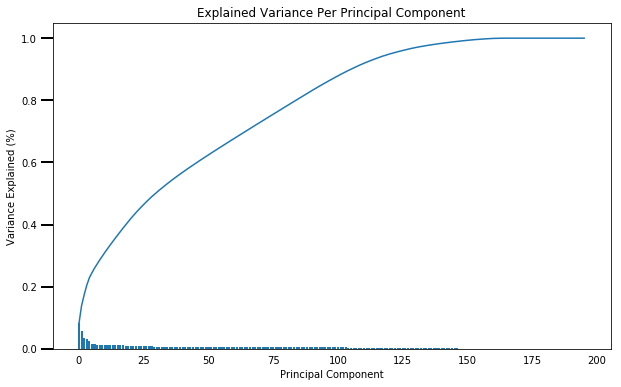

In [47]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)


In [48]:
vals = pca.explained_variance_ratio_
np.cumsum(vals)

array([ 0.08189948,  0.13864164,  0.17364996,  0.20427655,  0.2285296 ,
        0.24465173,  0.25965993,  0.27305702,  0.28593518,  0.2984326 ,
        0.31038028,  0.32219232,  0.33365251,  0.34499655,  0.35609062,
        0.36702355,  0.37784578,  0.38847607,  0.39888614,  0.40916814,
        0.4192974 ,  0.42902659,  0.43843396,  0.44753898,  0.45628175,
        0.46482061,  0.47314443,  0.48117193,  0.48910044,  0.49647016,
        0.50368461,  0.51078533,  0.51763501,  0.52435823,  0.53094081,
        0.53750448,  0.54394976,  0.55017293,  0.55631717,  0.56236677,
        0.5683522 ,  0.57419736,  0.57998865,  0.58569705,  0.59137211,
        0.5969828 ,  0.60257255,  0.6081076 ,  0.61362096,  0.61907503,
        0.62451026,  0.62991442,  0.63530929,  0.64065875,  0.6459833 ,
        0.65129134,  0.65658841,  0.66187762,  0.6671538 ,  0.672408  ,
        0.67765469,  0.68288305,  0.68810577,  0.69331746,  0.6985244 ,
        0.70372568,  0.70891976,  0.71410471,  0.71927893,  0.72

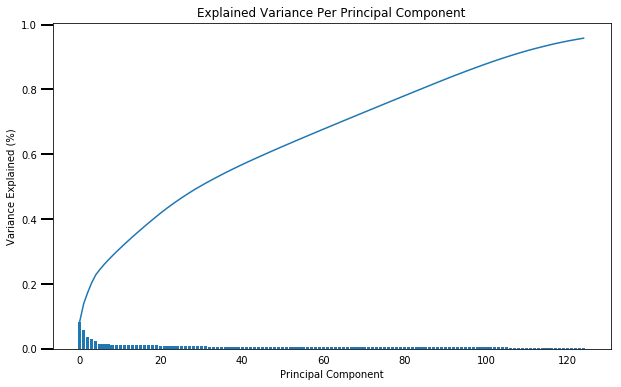

In [49]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca=PCA(n_components=125)
azdias_scaled_pca = pca.fit_transform(azdias_scaled)
scree_plot(pca)

In [50]:
vals = pca.explained_variance_ratio_
np.cumsum(vals)

array([ 0.08189948,  0.13864164,  0.17364996,  0.20427655,  0.2285296 ,
        0.24465173,  0.25965993,  0.27305702,  0.28593518,  0.2984326 ,
        0.31038028,  0.32219232,  0.33365251,  0.34499655,  0.35609062,
        0.36702355,  0.37784577,  0.38847607,  0.39888614,  0.40916814,
        0.4192974 ,  0.42902658,  0.43843395,  0.44753897,  0.45628175,
        0.46482061,  0.47314442,  0.4811719 ,  0.48910041,  0.49647013,
        0.50368458,  0.51078529,  0.51763497,  0.52435818,  0.53094074,
        0.5375044 ,  0.54394966,  0.55017279,  0.55631703,  0.56236662,
        0.56835204,  0.57419719,  0.57998848,  0.58569675,  0.59137174,
        0.59698236,  0.6025721 ,  0.60810714,  0.61362048,  0.61907453,
        0.62450963,  0.62991371,  0.63530853,  0.64065799,  0.64598252,
        0.65129047,  0.65658752,  0.6618767 ,  0.66715287,  0.67240696,
        0.67765363,  0.68288196,  0.68810467,  0.69331632,  0.69852322,
        0.70372447,  0.7089183 ,  0.71410321,  0.7192774 ,  0.72

### Discussion 2.2: Perform Dimensionality Reduction

In the initial default setting we can about 195 principal componets simialr to the number of columns we have orginally. But as we can see in the chart the explained variance flattens out at 125, meaning 95% of the variance is explained by 125PC's. So we will consider 125 PC's for our analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [51]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weights(pca,n):
    df_pca = pd.DataFrame(pca.components_, columns= list(azdias_scaled.columns))
    weights_pca = df_pca.iloc[n].sort_values(ascending=False)
    return weights_pca

def plot_pca_weights(pca,n,i=10):
    df_pca = pd.DataFrame(pca.components_, columns= list(azdias_scaled.columns))
    weights_pca = df_pca.iloc[n].sort_values(ascending=False)
    pca_n = pd.concat([pca_weights(pca,n).head(n=i), pca_weights(pca,n).tail(n=i)])
    pca_n.plot(kind='bar', title='Component '+str(n))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()


LP_STATUS_GROB_1.0                0.189158
HH_EINKOMMEN_SCORE                0.180079
CAMEO_INTL_2015_wealth            0.178604
PLZ8_ANTG3                        0.178301
PLZ8_ANTG4                        0.172737
PLZ8_BAUMAX                       0.169660
ORTSGR_KLS9                       0.152867
EWDICHTE                          0.151048
FINANZ_HAUSBAUER                  0.146708
KBA05_ANTG4                       0.126547
LP_STATUS_FEIN_1.0                0.125606
PLZ8_ANTG2                        0.122590
KBA05_ANTG3                       0.113779
ANZ_HAUSHALTE_AKTIV               0.113620
ARBEIT                            0.111116
CAMEO_DEUG_2015_9                 0.110343
LP_STATUS_FEIN_2.0                0.108003
RELAT_AB                          0.105116
LP_FAMILIE_FEIN_1.0               0.104179
LP_FAMILIE_GROB_1.0               0.104179
FINANZTYP_1                       0.103983
FINANZ_SPARER                     0.102182
CAMEO_DEUG_2015_8                 0.087697
SEMIO_PFLIC

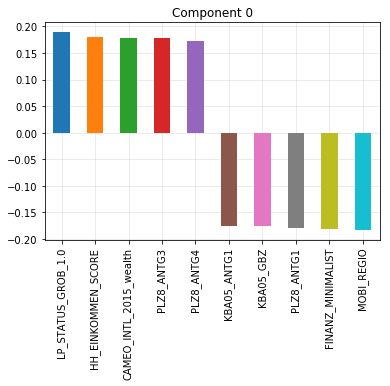

In [52]:
display(pca_weights(pca,0))
plot_pca_weights(pca,0,5)

ALTERSKATEGORIE_GROB            0.237128
FINANZ_VORSORGER                0.222822
ZABEOTYP_3                      0.199594
SEMIO_ERL                       0.181555
SEMIO_LUST                      0.166232
RETOURTYP_BK_S                  0.154688
W_KEIT_KIND_HH                  0.125119
CJT_GESAMTTYP_2.0               0.111526
FINANZ_MINIMALIST               0.099823
FINANZTYP_5                     0.098026
FINANZTYP_2                     0.097133
LP_STATUS_FEIN_1.0              0.086695
FINANZ_HAUSBAUER                0.077088
SHOPPER_TYP_3.0                 0.076107
CJT_GESAMTTYP_1.0               0.071934
SEMIO_KRIT                      0.071466
NATIONALITAET_KZ_1.0            0.070890
LP_FAMILIE_GROB_1.0             0.068737
LP_FAMILIE_FEIN_1.0             0.068737
FINANZTYP_6                     0.067453
GFK_URLAUBERTYP_4.0             0.058065
WOHNDAUER_2008                  0.055601
EWDICHTE                        0.053852
SEMIO_KAEM                      0.053768
ORTSGR_KLS9     

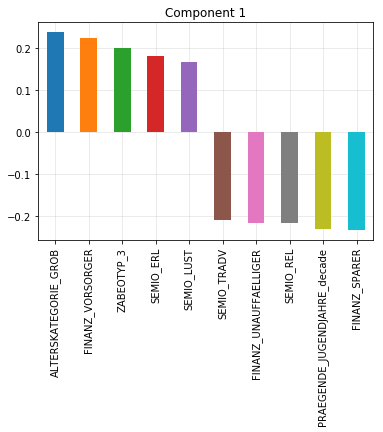

In [53]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

display(pca_weights(pca,1))
plot_pca_weights(pca,1,5)

SEMIO_VERT                        0.312744
SEMIO_FAM                         0.253507
SEMIO_SOZ                         0.253064
SEMIO_KULT                        0.245051
FINANZTYP_5                       0.139034
FINANZ_MINIMALIST                 0.130501
ZABEOTYP_1                        0.121744
SHOPPER_TYP_0.0                   0.120781
SEMIO_REL                         0.109674
PRAEGENDE_JUGENDJAHRE_movement    0.094398
GREEN_AVANTGARDE                  0.094398
SEMIO_MAT                         0.086019
ORTSGR_KLS9                       0.078917
EWDICHTE                          0.078152
RETOURTYP_BK_S                    0.073383
LP_STATUS_GROB_5.0                0.069411
LP_STATUS_FEIN_10.0               0.069411
PLZ8_BAUMAX                       0.058972
PLZ8_ANTG4                        0.057272
PLZ8_ANTG3                        0.056636
LP_STATUS_FEIN_3.0                0.047730
FINANZ_VORSORGER                  0.046840
ZABEOTYP_6                        0.045281
W_KEIT_KIND

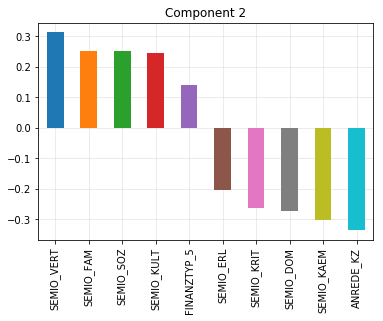

In [54]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

display(pca_weights(pca,2))
plot_pca_weights(pca,2,5)

### Discussion 2.3: Interpret Principal Components

The top PC's are LP_STATUS_GROB_1.0, HH_EINKOMMEN_SCORE and CAMEO_INTL_2015_wealth. Allt hese 3 variables correspond to family income/wealth. These have positive correaltion and it makes sense because al of them relate to family welath/income. MOBI_REGIO has negative corealtion meaining when the above 3 increases MOBI_REGIO decreases.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [55]:
# Kmeans score function
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [60]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
  # compute the average within-cluster distances.

scores = []
centers = list(range(1,30,2))

for center in centers:
    scores.append(get_kmeans_score(azdias_scaled_pca, center))
    

In [61]:
print(scores)

[149899187.90417561, 135697752.75960389, 130239998.48379076, 127417432.60007617, 124893537.56297489, 123056037.3045817, 121267694.82059596, 119892387.02377668, 118166540.80950351, 117389665.84670031, 116078394.39585216, 114617864.72332932, 112429685.88235022, 112529922.65486754, 110843802.57867219]


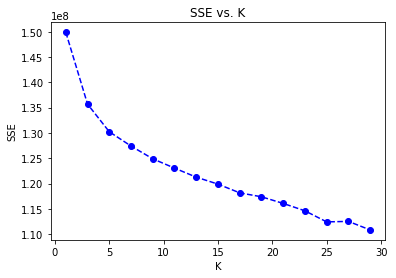

In [62]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [101]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
#Based on above chart the score tends to flatten out around 14 clusters, so we will use 14 clusters for our analysis.

kmeans_14 = KMeans(n_clusters=14)
model_14 = kmeans_14.fit(azdias_scaled_pca)
azdias_pred = model_14.predict(azdias_scaled_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [89]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [90]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,2,1,1,3
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,0,2,1,3,4
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0,0,0,0,0,0,1,0,2,4
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0,0,0,5,0,4,1
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,0,0,0,2,1,3,4


In [91]:
# Diff in columns between customer and azdias data set
list(set(customers_clean.columns)-set(azdias_clean.columns))

[]

In [92]:
# Diff in columns between azdias and customer data set. In GEBAEUDETYP in customer data there is field with 5.0 whereas
#in azdias data there a field in GEBAEUDETYP with 5.0, so we cna make GEBAEUDETYP_5.0 to 0.
list(set(azdias_clean.columns)-set(customers_clean.columns))

['GEBAEUDETYP_5.0']

In [93]:
#Create this column in customer dataset and make it to 0 since this exists in azdias dataset but not customer dataset
customers_clean['GEBAEUDETYP_5.0']=0

In [94]:
# Apply Feature scaling on customer data
customers_scaled = scaler.transform(customers_clean)

In [95]:
customers_scaled = pd.DataFrame(customers_scaled, columns=list(customers_clean))
customers_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage,GEBAEUDETYP_5.0
0,1.184107,-1.043937,1.409058,-1.155519,1.138172,-1.249987,-0.470414,-0.791197,1.885345,-1.633804,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,22.370561,-2.234266,1.885345,-0.187903,-1.920883
1,1.184107,0.957912,1.409058,-1.155519,1.138172,-1.249987,0.958633,0.629147,1.885345,-0.311824,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,22.370561,-2.234266,6.716850,0.493876,-1.920883
2,1.184107,-1.043937,1.409058,-1.155519,1.138172,-0.570999,-1.184938,-0.791197,-0.530407,-0.311824,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,11.140399,-2.775845,4.301097,0.493876,-1.920883
3,0.200522,-1.043937,-0.042768,-1.155519,0.411886,0.786977,1.673157,-0.791197,-0.530407,1.010156,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,56.061047,-2.775845,9.132602,-1.551461,-1.920883
4,0.200522,-1.043937,1.409058,-1.155519,1.138172,-1.249987,-0.470414,-0.081025,1.885345,1.010156,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,22.370561,-2.234266,6.716850,0.493876,-1.920883


In [96]:
# Apply pca to customer data

customers_scaled_pca = pca.transform(customers_scaled)
customers_scaled_pca.shape

(141725, 125)

In [102]:
# Predict on customers dataset

customers_pred = model_14.predict(customers_scaled_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [103]:
from collections import Counter

azdias_cluster_counts = Counter(azdias_pred)
azdias_cluster_counts

Counter({9: 26651,
         3: 57691,
         0: 75246,
         6: 98644,
         12: 55767,
         13: 45691,
         5: 56044,
         10: 85963,
         7: 25399,
         2: 57350,
         4: 38091,
         11: 74205,
         1: 51654,
         8: 49671})

In [104]:
customers_cluster_counts = Counter(customers_pred)
customers_cluster_counts

Counter({5: 32240,
         0: 12160,
         10: 23466,
         4: 6629,
         8: 38995,
         6: 8956,
         1: 12137,
         13: 760,
         7: 752,
         12: 3860,
         9: 1172,
         2: 318,
         11: 101,
         3: 179})

Text(0.5,1,'General-Data Clusters')

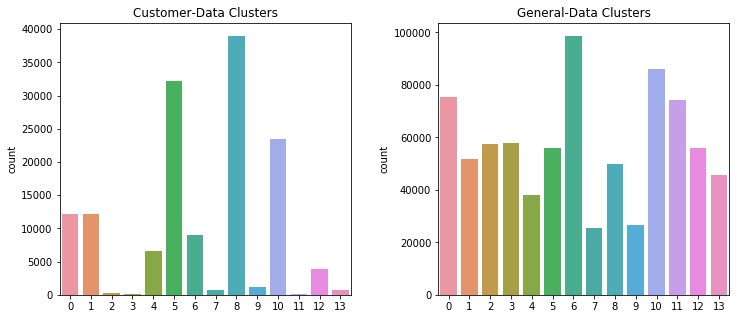

In [105]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (12,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customers_pred, ax=axs[0])
axs[0].set_title('Customer-Data Clusters')
sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General-Data Clusters')

In [106]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_8 = scaler.inverse_transform(pca.inverse_transform(customers_scaled_pca[np.where(customers_pred==8)])).round()
cluster_8

array([[  3.,   1.,   5., ...,   1.,   5.,   7.],
       [  4.,   1.,   5., ...,   1.,   5.,   5.],
       [  3.,   1.,   4., ...,   1.,   7.,  14.],
       ..., 
       [  4.,   1.,   5., ...,   1.,   5.,   7.],
       [  3.,   1.,   4., ...,   2.,   7.,   9.],
       [  4.,   1.,   5., ...,   1.,   4.,   6.]])

In [107]:
cluster_8_df = pd.DataFrame(data=cluster_8,
          index=np.array(range(0, cluster_8.shape[0])),
          columns=customers_scaled.columns)
cluster_8_df.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage,GEBAEUDETYP_5.0
0,3.0,1.0,5.0,0.0,5.0,0.0,2.0,3.0,1.0,1.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,3.0,4.0,1.0,5.0,7.0
1,4.0,1.0,5.0,1.0,4.0,0.0,2.0,2.0,1.0,1.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,2.0,4.0,1.0,5.0,5.0
2,3.0,1.0,4.0,2.0,2.0,2.0,5.0,2.0,1.0,2.0,...,-0.0,-1.0,-1.0,-1.0,-1.0,7.0,8.0,1.0,7.0,14.0
3,4.0,1.0,5.0,1.0,4.0,1.0,4.0,2.0,2.0,1.0,...,-0.0,-1.0,-1.0,-1.0,-1.0,6.0,6.0,2.0,7.0,12.0
4,2.0,1.0,4.0,1.0,4.0,0.0,3.0,3.0,2.0,1.0,...,-0.0,-1.0,-1.0,-1.0,-1.0,5.0,6.0,2.0,8.0,10.0
5,2.0,1.0,5.0,1.0,4.0,2.0,2.0,2.0,1.0,3.0,...,-0.0,-1.0,-1.0,-1.0,-1.0,5.0,6.0,1.0,7.0,10.0
6,4.0,1.0,5.0,1.0,5.0,0.0,2.0,2.0,1.0,1.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,3.0,4.0,1.0,4.0,8.0
7,3.0,2.0,4.0,1.0,4.0,2.0,2.0,3.0,2.0,2.0,...,-0.0,-1.0,-1.0,-1.0,-1.0,6.0,6.0,2.0,7.0,11.0
8,3.0,1.0,4.0,0.0,5.0,0.0,2.0,4.0,1.0,2.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,3.0,3.0,1.0,5.0,6.0
9,4.0,2.0,5.0,0.0,6.0,1.0,1.0,3.0,1.0,2.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,3.0,1.0,3.0,3.0


In [108]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_6 = scaler.inverse_transform(pca.inverse_transform(customers_scaled_pca[np.where(customers_pred==6)])).round()
cluster_6

array([[  3.,   1.,   3., ...,   1.,   5.,   5.],
       [  4.,   1.,   4., ...,   2.,   5.,   5.],
       [  3.,   1.,   3., ...,   2.,   6.,   6.],
       ..., 
       [  4.,   1.,   3., ...,   1.,   4.,   5.],
       [  3.,   1.,   4., ...,   1.,   5.,   5.],
       [  2.,   1.,   3., ...,   1.,   7.,  10.]])

In [109]:
cluster_6_df = pd.DataFrame(data=cluster_6,
          index=np.array(range(0, cluster_6.shape[0])),
          columns=customers_scaled.columns)
cluster_6_df.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage,GEBAEUDETYP_5.0
0,3.0,1.0,3.0,1.0,5.0,1.0,1.0,5.0,1.0,2.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,3.0,3.0,1.0,5.0,5.0
1,4.0,1.0,4.0,0.0,5.0,0.0,2.0,4.0,2.0,1.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,2.0,3.0,2.0,5.0,5.0
2,3.0,1.0,3.0,0.0,6.0,-0.0,1.0,6.0,2.0,2.0,...,-0.0,-0.0,0.0,-0.0,-1.0,3.0,3.0,2.0,6.0,6.0
3,1.0,1.0,3.0,1.0,4.0,-0.0,3.0,4.0,2.0,2.0,...,-0.0,-1.0,-1.0,-1.0,-1.0,6.0,6.0,2.0,10.0,13.0
4,3.0,1.0,4.0,1.0,5.0,0.0,2.0,5.0,2.0,2.0,...,-0.0,-0.0,-0.0,1.0,-0.0,2.0,3.0,2.0,5.0,4.0
5,3.0,1.0,4.0,1.0,5.0,-0.0,2.0,5.0,2.0,3.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,3.0,2.0,4.0,2.0
6,4.0,1.0,3.0,0.0,5.0,-0.0,2.0,5.0,2.0,2.0,...,-0.0,-0.0,-1.0,0.0,-1.0,3.0,4.0,2.0,6.0,6.0
7,4.0,1.0,3.0,1.0,5.0,-0.0,2.0,5.0,2.0,2.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,2.0,3.0,2.0,5.0,5.0
8,3.0,1.0,3.0,1.0,5.0,1.0,1.0,5.0,2.0,1.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,2.0,2.0,4.0,2.0
9,3.0,1.0,4.0,0.0,5.0,0.0,2.0,4.0,2.0,3.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,2.0,3.0,2.0,5.0,7.0


In [121]:
display(pca_weights(pca,0))

LP_STATUS_GROB_1.0                0.189158
HH_EINKOMMEN_SCORE                0.180079
CAMEO_INTL_2015_wealth            0.178604
PLZ8_ANTG3                        0.178301
PLZ8_ANTG4                        0.172737
PLZ8_BAUMAX                       0.169660
ORTSGR_KLS9                       0.152867
EWDICHTE                          0.151048
FINANZ_HAUSBAUER                  0.146708
KBA05_ANTG4                       0.126547
LP_STATUS_FEIN_1.0                0.125606
PLZ8_ANTG2                        0.122590
KBA05_ANTG3                       0.113779
ANZ_HAUSHALTE_AKTIV               0.113620
ARBEIT                            0.111116
CAMEO_DEUG_2015_9                 0.110343
LP_STATUS_FEIN_2.0                0.108003
RELAT_AB                          0.105116
LP_FAMILIE_FEIN_1.0               0.104179
LP_FAMILIE_GROB_1.0               0.104179
FINANZTYP_1                       0.103983
FINANZ_SPARER                     0.102182
CAMEO_DEUG_2015_8                 0.087697
SEMIO_PFLIC

### Discussion 3.3: Compare Customer Data to Demographics Data

From the graph we can see that cluster 8 and 5 are overrepresented in customers data compared to general population. These are tthe customers which are highly probable customer segments for mail order company. Similarly cluster 6,11,12 and 13 are underrepresented in customer data compared to general data.
Incopme status play a major influencer for components weights.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.